In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import os
import re
import numpy as np
from numpy import mean, median
# import seaborn as sns
import pandas as pd
import math
import sys
if "../" not in sys.path:
    sys.path.append("../")
matplotlib.style.use('ggplot')

In [2]:
# load files and add saved models data into one dictionary
rootdir = '../saved_models_all/'
count = 0
all_data_dict = {'base': {},
                'newly_introduced': {}
                }

for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        count += 1
        new_dict = np.load(os.path.join(subdir, file), allow_pickle='TRUE')        
        source_id_str = str(int(new_dict.item()['config']['generic']['w_volte']*100)) + \
        str(int(new_dict.item()['config']['generic']['w_urllc']*100)) \
        + str(int(new_dict.item()['config']['generic']['w_video']*100))
             
        if (subdir == rootdir + 'non_accelerated'):
            if source_id_str not in all_data_dict['newly_introduced']:
                all_data_dict['newly_introduced'][source_id_str] = {}

            if 'non_accelerated' not in all_data_dict['newly_introduced'][source_id_str]:
                all_data_dict['newly_introduced'][source_id_str]['non_accelerated'] = {}                
    
            all_data_dict['newly_introduced'][source_id_str]['non_accelerated']['config'] = new_dict.item()['config']
            all_data_dict['newly_introduced'][source_id_str]['non_accelerated']['rewards'] = new_dict.item()['rewards']

        elif (subdir == rootdir + 'tf_accelerated'):
            result = re.search('_by_(.*)_', file)                        
            by_id_str = result.group(1)

            if source_id_str not in all_data_dict['newly_introduced']:
                all_data_dict['newly_introduced'][source_id_str] = {}
                
            if by_id_str not in all_data_dict['newly_introduced'][source_id_str]:
                all_data_dict['newly_introduced'][source_id_str][by_id_str] = {}            
            
            all_data_dict['newly_introduced'][source_id_str][by_id_str]['config'] = new_dict.item()['config']
            all_data_dict['newly_introduced'][source_id_str][by_id_str]['rewards'] = new_dict.item()['rewards']
            all_data_dict['newly_introduced'][source_id_str][by_id_str]['config']['generic']['by_w_volte'] = int(by_id_str[0:1])/10
            all_data_dict['newly_introduced'][source_id_str][by_id_str]['config']['generic']['by_w_urllc'] = int(by_id_str[2:3])/10
            all_data_dict['newly_introduced'][source_id_str][by_id_str]['config']['generic']['by_w_video'] = int(by_id_str[4:5])/10

        elif (subdir == rootdir + 'me_accelerated'):
            result = re.search('_by_(.*)_', file)                        
            by_id_str = result.group(1)

            if source_id_str not in all_data_dict['newly_introduced']:
                all_data_dict['newly_introduced'][source_id_str] = {}
                
            if by_id_str not in all_data_dict['newly_introduced'][source_id_str]:
                all_data_dict['newly_introduced'][source_id_str][by_id_str] = {}            
            
            all_data_dict['newly_introduced'][source_id_str][by_id_str]['config'] = new_dict.item()['config']
            all_data_dict['newly_introduced'][source_id_str][by_id_str]['rewards'] = new_dict.item()['rewards']
            all_data_dict['newly_introduced'][source_id_str][by_id_str]['config']['generic']['by_w_volte'] = 'meta'
            all_data_dict['newly_introduced'][source_id_str][by_id_str]['config']['generic']['by_w_urllc'] = ''
            all_data_dict['newly_introduced'][source_id_str][by_id_str]['config']['generic']['by_w_video'] = 'dqn'

        elif (subdir == rootdir + 'm2_accelerated'):
            result = re.search('_by_(.*)_', file)                        
            by_id_str = result.group(1)
            if source_id_str not in all_data_dict['newly_introduced']:
                all_data_dict['newly_introduced'][source_id_str] = {}                
            if by_id_str not in all_data_dict['newly_introduced'][source_id_str]:
                all_data_dict['newly_introduced'][source_id_str][by_id_str] = {}            
            all_data_dict['newly_introduced'][source_id_str][by_id_str]['config'] = new_dict.item()['config']
            all_data_dict['newly_introduced'][source_id_str][by_id_str]['rewards'] = new_dict.item()['rewards']
            all_data_dict['newly_introduced'][source_id_str][by_id_str]['config']['generic']['by_w_volte'] = 'm2'
            all_data_dict['newly_introduced'][source_id_str][by_id_str]['config']['generic']['by_w_urllc'] = ''
            all_data_dict['newly_introduced'][source_id_str][by_id_str]['config']['generic']['by_w_video'] = 'dqn'
            
        elif (subdir == rootdir + 'mt_accelerated'):
            result = re.search('_by_(.*)_', file)                        
            by_id_str = result.group(1)
            if source_id_str not in all_data_dict['newly_introduced']:
                all_data_dict['newly_introduced'][source_id_str] = {}                
            if by_id_str not in all_data_dict['newly_introduced'][source_id_str]:
                all_data_dict['newly_introduced'][source_id_str][by_id_str] = {}            
            all_data_dict['newly_introduced'][source_id_str][by_id_str]['config'] = new_dict.item()['config']
            all_data_dict['newly_introduced'][source_id_str][by_id_str]['rewards'] = new_dict.item()['rewards']
            all_data_dict['newly_introduced'][source_id_str][by_id_str]['config']['generic']['by_w_volte'] = 'multi-task'
            all_data_dict['newly_introduced'][source_id_str][by_id_str]['config']['generic']['by_w_urllc'] = ''
            all_data_dict['newly_introduced'][source_id_str][by_id_str]['config']['generic']['by_w_video'] = 'dqn'

In [3]:
column_names1 = list(all_data_dict['base'].keys())
error_df = pd.DataFrame(columns = column_names1)
distance_df = pd.DataFrame(columns = column_names1)

column_names2 = ['w_volte', 'w_urllc', 'w_video', 'error', 'distance', 'by_w_volte', 'by_w_urllc', 'by_w_video']
generic_df = pd.DataFrame(columns = column_names2)

weight_distance = []
reward_error = []
positive_reward_error = []
weight_introduced = []
weight_by = []
count = 0


for weight_comb in all_data_dict['newly_introduced']:
    generic_row_holder = []
    error_row_holder = []
    distance_row_holder = []

    for model, v in sorted(all_data_dict['newly_introduced'][weight_comb].items()):
        if model == 'non_accelerated':
            continue

        error =  max(all_data_dict['newly_introduced'][weight_comb]['non_accelerated']['rewards']['episodes']- \
            max(all_data_dict['newly_introduced'][weight_comb][model]['rewards']['episodes']) )
        
        dist = np.linalg.norm(np.array([int(weight_comb[0])/10, int(weight_comb[1])/10, int(weight_comb[2])/10])\
                      - np.array([int(model[0])/10, int(model[1])/10, int(model[2])/10]))
                
        reward_error.append(error)
        weight_distance.append(dist)
        error_row_holder.append(error)
        distance_row_holder.append(dist)
        weight_introduced.append(weight_comb)
        weight_by.append(model)
        
        w_volte = all_data_dict['newly_introduced'][weight_comb][model]['config']['generic']['w_volte']
        w_urllc = all_data_dict['newly_introduced'][weight_comb][model]['config']['generic']['w_urllc']
        w_video = all_data_dict['newly_introduced'][weight_comb][model]['config']['generic']['w_video']

        by_w_volte = all_data_dict['newly_introduced'][weight_comb][model]['config']['generic']['by_w_volte']
        by_w_urllc = all_data_dict['newly_introduced'][weight_comb][model]['config']['generic']['by_w_urllc']
        by_w_video = all_data_dict['newly_introduced'][weight_comb][model]['config']['generic']['by_w_video']

        generic_row_holder = [w_volte, w_urllc, w_video, error, dist, by_w_volte, by_w_urllc, by_w_video]
        generic_df.loc[len(generic_df.index)] = generic_row_holder
        
        if error > 0:
            positive_reward_error.append([weight_comb, model])
        count += 1

In [4]:
base = np.zeros((91, 50))
mt = np.zeros((91, 50))
meta = np.zeros((91, 50))
m2 = np.zeros((91, 50))
e_101080 = np.zeros((91, 50))
e_102070 = np.zeros((91, 50))
e_103060 = np.zeros((91, 50))
e_104050 = np.zeros((91, 50))
e_104545 = np.zeros((91, 50))
e_105040 = np.zeros((91, 50))
e_106030 = np.zeros((91, 50))
e_107020 = np.zeros((91, 50))
e_108010 = np.zeros((91, 50))
e_333333 = np.zeros((91, 50))
e_401050 = np.zeros((91, 50))
e_402040 = np.zeros((91, 50))
e_403030 = np.zeros((91, 50))
e_404020 = np.zeros((91, 50))
e_405010 = np.zeros((91, 50))
e_801010 = np.zeros((91, 50))


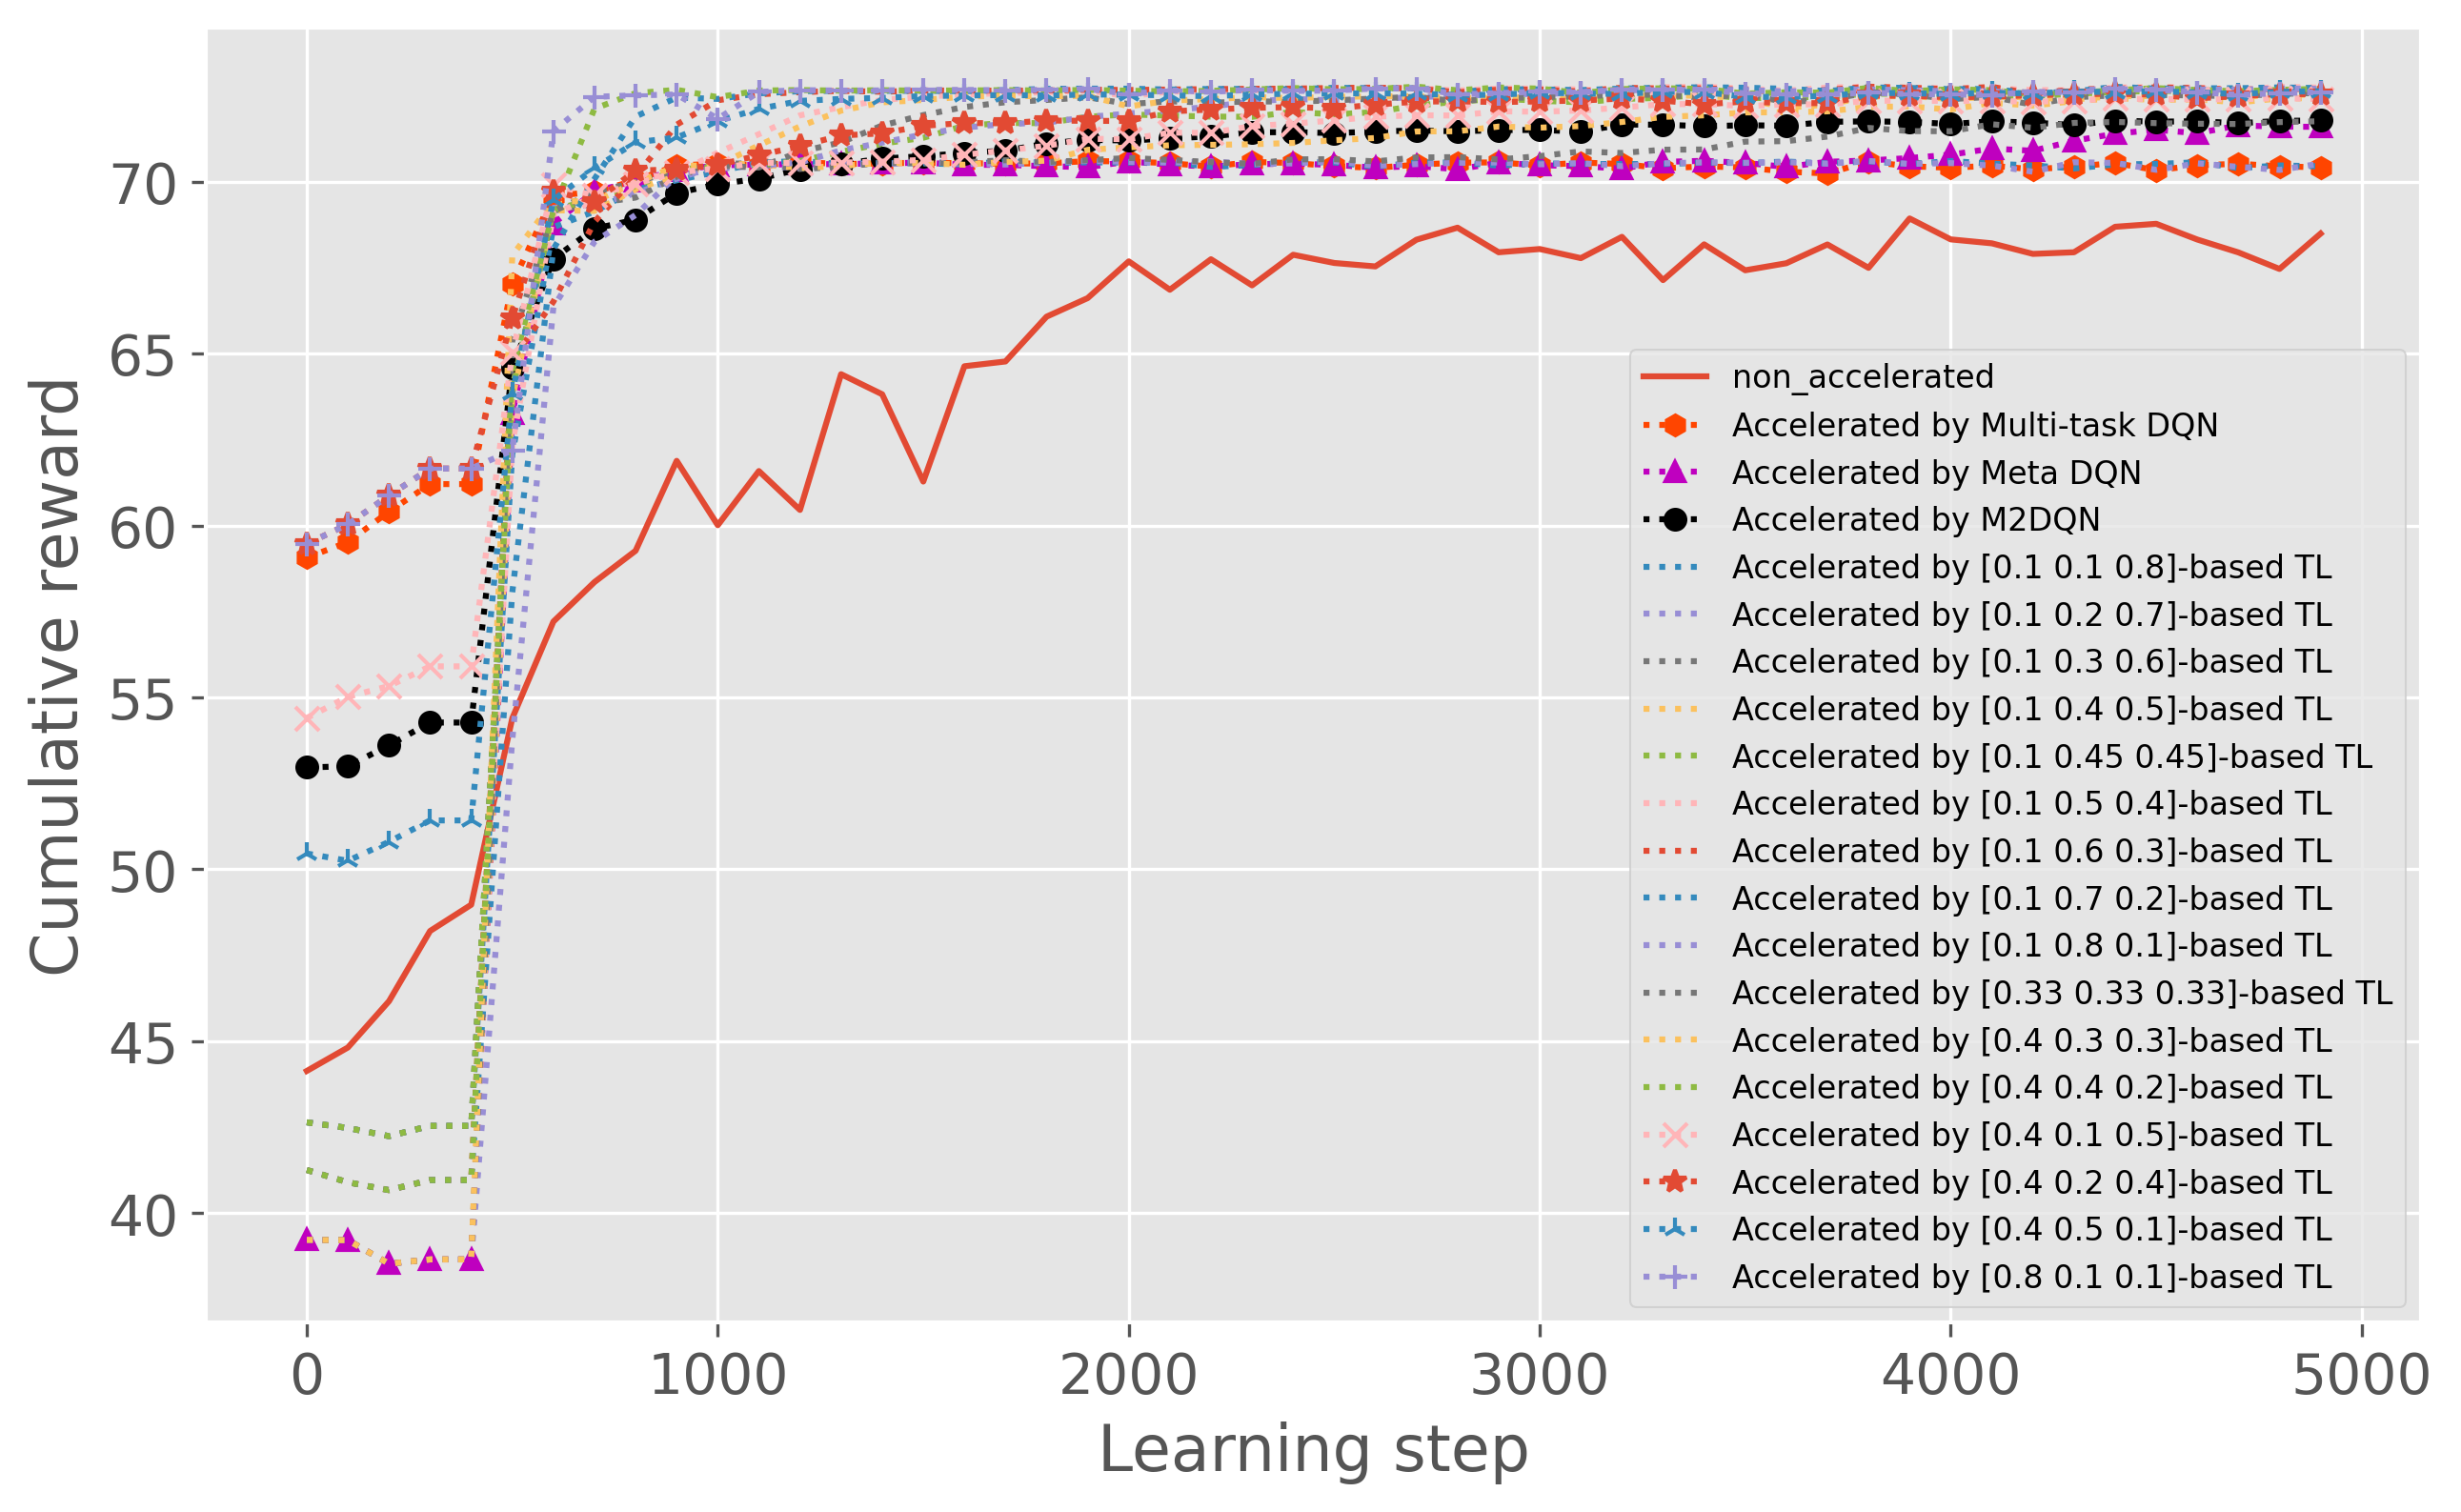

In [5]:
# expert_model = ['101080','102070','103060','104050','104545','105040','106030','107020','108010',\
#                '333333','401050','402040','403030','404020','405010','801010']
index_i = 0

for weight_comb in all_data_dict['newly_introduced']:

    model = 'non_accelerated'
    base[index_i] = all_data_dict['newly_introduced'][weight_comb][model]['rewards']['episodes']
    model = '111111'
    mt[index_i] = all_data_dict['newly_introduced'][weight_comb][model]['rewards']['episodes']
    model = '222222'
    meta[index_i] = all_data_dict['newly_introduced'][weight_comb][model]['rewards']['episodes']
    model = '444444'
    m2[index_i] = all_data_dict['newly_introduced'][weight_comb][model]['rewards']['episodes']
    
    model = '101080'
    e_101080[index_i] = all_data_dict['newly_introduced'][weight_comb][model]['rewards']['episodes']
    model = '102070'
    e_102070[index_i] = all_data_dict['newly_introduced'][weight_comb][model]['rewards']['episodes']
    model = '103060'
    e_103060[index_i] = all_data_dict['newly_introduced'][weight_comb][model]['rewards']['episodes']
    model = '104050'
    e_104050[index_i] = all_data_dict['newly_introduced'][weight_comb][model]['rewards']['episodes']
    model = '104545'
    e_104545[index_i] = all_data_dict['newly_introduced'][weight_comb][model]['rewards']['episodes']
    model = '105040'
    e_105040[index_i] = all_data_dict['newly_introduced'][weight_comb][model]['rewards']['episodes']
    model = '106030'
    e_106030[index_i] = all_data_dict['newly_introduced'][weight_comb][model]['rewards']['episodes']
    model = '107020'
    e_107020[index_i] = all_data_dict['newly_introduced'][weight_comb][model]['rewards']['episodes']
    model = '108010'
    e_108010[index_i] = all_data_dict['newly_introduced'][weight_comb][model]['rewards']['episodes']
    model = '333333'
    e_333333[index_i] = all_data_dict['newly_introduced'][weight_comb][model]['rewards']['episodes']
    model = '401050'
    e_401050[index_i] = all_data_dict['newly_introduced'][weight_comb][model]['rewards']['episodes']
    model = '402040'
    e_402040[index_i] = all_data_dict['newly_introduced'][weight_comb][model]['rewards']['episodes']
    model = '403030'
    e_403030[index_i] = all_data_dict['newly_introduced'][weight_comb][model]['rewards']['episodes']
    model = '404020'
    e_404020[index_i] = all_data_dict['newly_introduced'][weight_comb][model]['rewards']['episodes']
    model = '405010'
    e_405010[index_i] = all_data_dict['newly_introduced'][weight_comb][model]['rewards']['episodes']
    model = '801010'
    e_801010[index_i] = all_data_dict['newly_introduced'][weight_comb][model]['rewards']['episodes']  
    
    index_i += 1

X = np.arange(0, 50, 1)*100
plt.figure(figsize=(10, 6), dpi=300)
ax = plt.subplot(111)
ax.plot(X, base.mean(axis=0), label= 'non_accelerated')
ax.plot(X, mt.mean(axis=0), ls='dotted', marker="h",color='orangered', markersize=5,  label= 'Accelerated by Multi-task DQN')
ax.plot(X, meta.mean(axis=0), ls='dotted', marker="^",color='m',markersize=5,   label= 'Accelerated by Meta DQN')
ax.plot(X, m2.mean(axis=0), ls='dotted', marker="o",color='black', markersize=5, label= 'Accelerated by M2DQN')

ax.plot(X, e_101080.mean(axis=0), ls='dotted', label= 'Accelerated by [0.1 0.1 0.8]')
ax.plot(X, e_102070.mean(axis=0), ls='dotted', label= 'Accelerated by [0.1 0.2 0.7]')
ax.plot(X, e_103060.mean(axis=0), ls='dotted', label= 'Accelerated by [0.1 0.3 0.6]')
ax.plot(X, e_104050.mean(axis=0), ls='dotted', label= 'Accelerated by [0.1 0.4 0.5]')
ax.plot(X, e_104545.mean(axis=0), ls='dotted', label= 'Accelerated by [0.1 0.45 0.45]')
ax.plot(X, e_333333.mean(axis=0), ls='dotted', label= 'Accelerated by [0.33 0.33 0.33]')
ax.plot(X, e_105040.mean(axis=0), ls='dotted', label= 'Accelerated by [0.1 0.5 0.4]')
ax.plot(X, e_106030.mean(axis=0), ls='dotted', label= 'Accelerated by [0.1 0.6 0.3]')
ax.plot(X, e_107020.mean(axis=0), ls='dotted', label= 'Accelerated by [0.1 0.7 0.2]')
ax.plot(X, e_108010.mean(axis=0), ls='dotted', label= 'Accelerated by [0.1 0.8 0.1]')
ax.plot(X, e_403030.mean(axis=0), ls='dotted', label= 'Accelerated by [0.4 0.3 0.3]')
ax.plot(X, e_404020.mean(axis=0), ls='dotted', label= 'Accelerated by [0.4 0.4 0.2]')
ax.plot(X, e_401050.mean(axis=0), ls='dotted', marker="x", label= 'Accelerated by [0.4 0.1 0.5]')
ax.plot(X, e_402040.mean(axis=0), ls='dotted', marker="*", label= 'Accelerated by [0.4 0.2 0.4]')
ax.plot(X, e_405010.mean(axis=0), ls='dotted', marker="2", label= 'Accelerated by [0.4 0.5 0.1]')
ax.plot(X, e_801010.mean(axis=0), ls='dotted',  marker="+", label= 'Accelerated by [0.8 0.1 0.1]')

ax.legend(fontsize=11,ncol=2)
# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Learning step", fontsize=16)
plt.ylabel("Cumulative reward", fontsize=16)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.show()

In [6]:
df = pd.DataFrame(columns=['learner','expert','accelerated_reward','non_accelerated_reward'])

for weight_comb in all_data_dict['newly_introduced']:
    for model in all_data_dict['newly_introduced'][weight_comb]:        
        accelerated_reward = all_data_dict['newly_introduced'][weight_comb][model]['rewards']['episodes'][0]
        non_accelerated_reward = all_data_dict['newly_introduced'][weight_comb]['non_accelerated']['rewards']['episodes'][0]
        if model == '444444':
            model = 'M2DQN'
        elif model == '222222':
            model = 'Meta'
        elif model == '111111':
            model = 'Multi-task'
        new_row = {'learner':weight_comb,\
                   'expert':model, \
                  'accelerated_reward':accelerated_reward,\
                  'non_accelerated_reward':non_accelerated_reward}
        df = df.append(new_row, ignore_index = True)
df['gain']=df['accelerated_reward']-df['non_accelerated_reward']
df['gain_flag']=df['accelerated_reward']>df['non_accelerated_reward']

In [ ]:
df.to_csv('df.csv', index=0)

In [7]:
pd.crosstab(index=df['expert'], columns=df['gain_flag'])

gain_flag,False,True
expert,,
101080,50,41
102070,50,41
103060,50,41
104050,58,33
104545,50,41
105040,47,44
106030,47,44
107020,47,44
108010,58,33


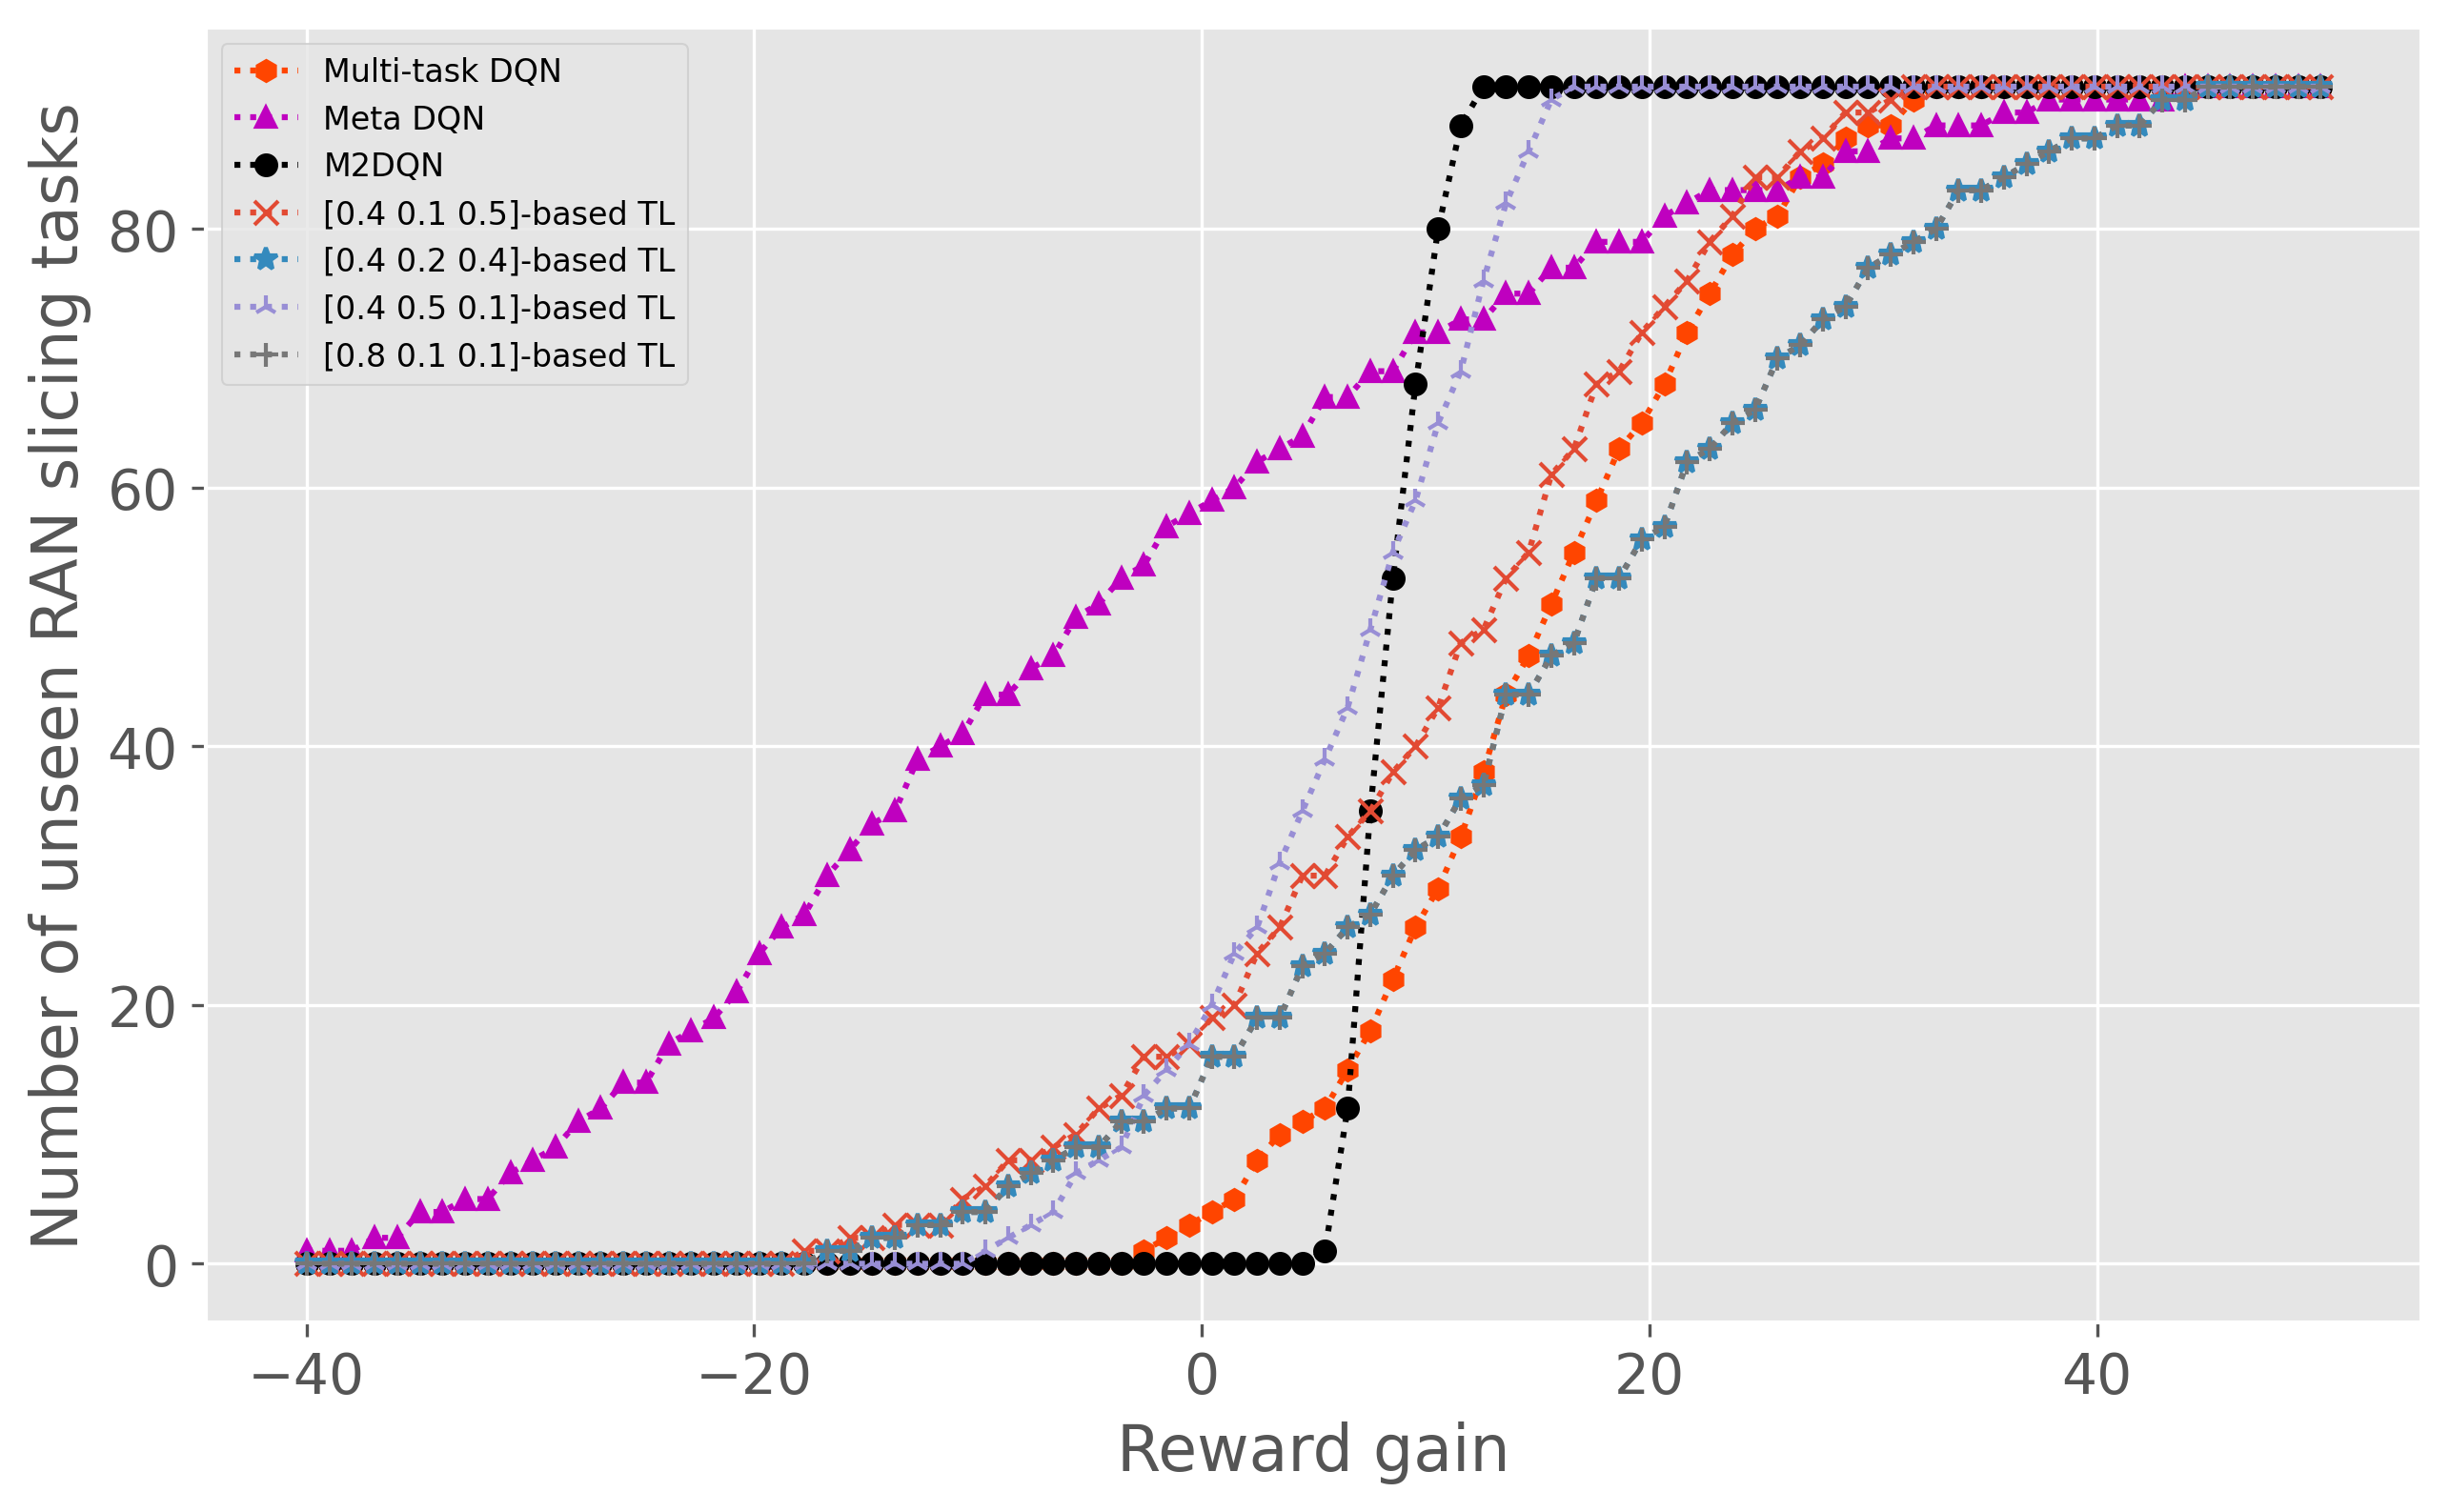

In [8]:
models = ['Multi-task','Meta','M2DQN','401050','402040','405010','801010']

plt.figure(figsize=(10, 6), dpi=300)
ax = plt.subplot(111)

for m in models:
    data = df[df['expert']==m]['accelerated_reward']-df[df['expert']==m]['non_accelerated_reward']
    bins=np.linspace(-40,50,91)
    di = np.histogram(data,bins)
    cumulative_prob=np.cumsum(di[0])
    if m == 'Multi-task':
        ax.plot(np.linspace(-40,50,90),cumulative_prob, ls='dotted', color='orangered',marker="h",markersize=5,  label='Multi-task DQN')
    if m == 'Meta':
        ax.plot(np.linspace(-40,50,90),cumulative_prob, ls='dotted', color='m',marker="^",markersize=5,  label='Meta DQN')
    if m == 'M2DQN':
        ax.plot(np.linspace(-40,50,90),cumulative_prob, ls='dotted', color='black', marker="o",markersize=5,  label='M2DQN')
    if m == '401050':
        ax.plot(np.linspace(-40,50,90),cumulative_prob, ls='dotted', marker="x",  label='Accelerated by [0.4 0.1 0.5]')
    if m == '402040':
        ax.plot(np.linspace(-40,50,90),cumulative_prob, ls='dotted', marker="*",  label='Accelerated by [0.4 0.2 0.4]')
    if m == '405010':
        ax.plot(np.linspace(-40,50,90),cumulative_prob, ls='dotted', marker="2",  label='Accelerated by [0.4 0.5 0.1]')
    if m == '801010':
        ax.plot(np.linspace(-40,50,90),cumulative_prob, ls='dotted', marker="+",  label='Accelerated by [0.8 0.1 0.1]')
    
ax.legend(fontsize=11)
# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Reward gain", fontsize=16)
plt.ylabel("Number of unseen RAN slicing tasks", fontsize=16)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.show()

